In [13]:
import nltk # 영어 기호, 통계, 자연어 처리를 위한 라이브러리
nltk.download('stopwords') # NLTK의 불용어 사용

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('불러온 샘플수 :', (len(data)))

불러온 샘플수 : 98401


In [5]:
# #랜덤한 10개 샘플 출력
data.sample(10)

# 추상적 요약을 하는 경우에는 text(Text)를 본문, headlines(Summary)를 이미 요약된 데이터로 삼아서 모델을 학습

,headlines,text
46737,Transformation by transportation my vision for...,"Speaking at an election rally in Nagaland, Pri..."
80995,Sonam to be part of Harvard Business School pa...,Sonam Kapoor is set to join the Harvard Busine...
47914,Tease your taste buds with Cornetto Oreo this ...,Have you heard about Alia's new found love? Th...
73540,"Will ensure Murthy, Infosys have good relation...","Infosys Co-founder Nandan Nilekani, who was ap..."
12153,Aegon Life iTerm offers life cover upto 100 years,Safeguard yourself against life's unpleasant s...
115,"Don't play around with the law, SC warns Karti...",The Supreme Court today allowed former Finance...
20301,Musk hires Morgan Stanley to help take Tesla p...,Tesla CEO Elon Musk has reportedly hired Ameri...
68701,"Pakistani actor recreates Ranbir, Mahira's smo...",Pakistani actor Osman Khalid Butt recreated Ra...
94390,AI pilot grounded for 3 months after failing a...,An Air India pilot has been grounded for three...
5493,"Case filed against MP CM over remark on UP, Bi...",A case has been filed in Bihar against Madhya ...


### 데이터 전처리

In [7]:
# 중복 확인 
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique()) 
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [8]:
# 중복 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
# null값 확인 
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [11]:
# 텍스트 정규화 >> 연산량을 줄여줌
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [14]:
# NTLK의 불용어를 이용해서 제거 
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [16]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [17]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary(headline):", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않을 때, False

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary(headline): great way to start the day


**위의 결과를 통해 알 수 있는 것들**  

    * 알파벳이 모두 소문자로 변환
    * <br />과 같은 html 태그 제거
    * (or finish)와 같은 괄호로 묶인 단어  시퀀스 제거 
    * 특수문자 제거

In [18]:
# 전체 Text 데이터에 대한 전처리

clean_text = [preprocess_sentence(sentence) for sentence in data['text']]

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [19]:
import copy
clean_text_copy = copy.deepcopy(clean_text)

In [20]:
# 전체 Summary 데이터에 대한 전처리 

clean_summary = [preprocess_sentence(sentence, False) for sentence in data['headlines']]

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [21]:
clean_summary_copy = copy.deepcopy(clean_summary)

In [22]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 텍스트 정제 이후에는 다시 한번 empty 값 존재를 확인해 보는 것이 좋음
# 만약 empty 값을 가진 샘플이 있다면 모두 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [23]:
# null 값 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [24]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


##### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


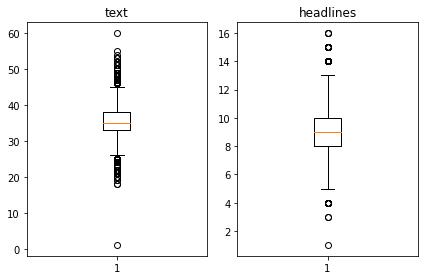

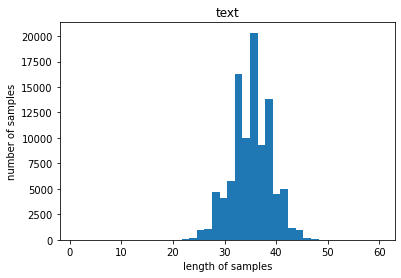

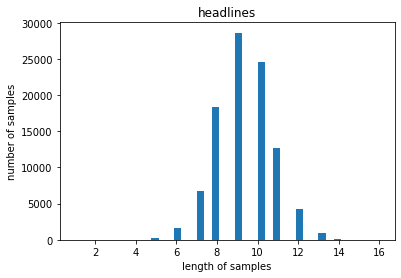

In [25]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
# 임의로 적절하게 정함
text_max_len = 40
summary_max_len = 10

In [27]:
# 임의로 정한 값에 의해서 샘플이 몇 % 를 포함하는지 확인 
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [29]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [30]:
# 정해진 길이에 맞추지 않고 정해진 길이보다 길면 제외하는 방식으로 데이터 정제

data = data[data.apply(lambda x:len(x['text'].split()) <= text_max_len and len(x['headlines'].split()) <= summary_max_len, axis = 1)]

print('전체 샘플 수 ', (len(data)))

전체 샘플 수  74102


##### 시작 토큰과 종료 토큰 추가
    * 디코더는 시작 토큰을 입력 받아 문자 생성 시작, 종료 토큰에 문장 생성을 멈춤 
    * 시작 토큰 : sostoken >> decoder input
    * 종료 토큰 : eostoken >> decoder target
    * Summary로 만듬

In [31]:
# 시작, 종료 토큰 추가 
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

/tmp/ipykernel_54/417454917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
/tmp/ipykernel_54/417454917.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [32]:
# numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [33]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어 줌
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[42468 23015 57898 ... 17331 19164 68216]


In [34]:
# 만든 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플로 만듬
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [35]:
# 8:2 비율로 만듬
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14820


In [36]:
# 훈련, 테스트 셋으로 만들기 
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


##### 정수 인코딩
    * 모델 학습을 위해 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꿔주기
    * 단어 집합(vocabulary) 만들기 :  각 단어에 고유한 정수를 맵핑하는 작업을 말함
    * keras의 토크나이저를 사용해서, 훈련 데이터로 부터 단어 집합 만들기
    * 만들어진 단어 집합은 src_tokenizer.word_index에 저장되어 있음
    * 빈도 수 낮은 단어는 제외하고 학습 진행
    * src_tokenizer.word_counts.items() : 단어와 각 단어의 등장 빈도수가 저장
    * texts_to_sequences() : 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행 >> 이후에는 데이터에 존재하지 않음

In [37]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [38]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61595
등장 빈도가 6번 이하인 희귀 단어의 수: 42251
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19344
단어 집합에서 희귀 단어의 비율: 68.59485347836674
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.18821068427166


**위의 결과에서 알 수 있는 것들**   

    * threshold인 7회 미만인 단어들이 68% 이상 차지
    * 해당 단어들을 정수 인코딩 과정에서 빼고 훈련 데이터에서 제거하기 


In [39]:
src_vocab = 9000 # 제거 후 단어 집합의 크기를 약 9000개로 제한 
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 약 9,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [40]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력 >> 정수 출력 
print(encoder_input_train[:3])

[[5744, 4335, 4087, 1373, 2764, 247, 3246, 2880, 197, 7, 68, 1, 7482, 7968, 258, 688, 1215, 3656, 426, 6543, 2378, 394, 6544, 292, 1, 4335, 2777, 699, 84, 6545, 1936, 5744, 8821, 863], [22, 43, 5668, 519, 1491, 892, 608, 278, 333, 139, 190, 66, 28, 2, 36, 22, 105, 1161, 278, 73, 3, 54, 231, 593, 28, 2, 5, 540, 1139, 946, 253, 66, 66, 1264, 35, 134], [13, 57, 119, 47, 922, 1238, 57, 22, 266, 5086, 6981, 6546, 143, 1313, 154, 1783, 7483, 89, 3, 2314, 103, 57, 22, 266, 1720, 314, 595, 324, 5325, 283, 413]]


In [41]:
## headlines에도 동일한 작업 수행 

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [42]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27213
등장 빈도가 5번 이하인 희귀 단어의 수: 18128
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9085
단어 집합에서 희귀 단어의 비율: 66.61522066659317
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.951075343559008


In [43]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 11, 130, 163, 49], [1, 1500, 1064, 88, 142, 179, 4, 24, 105], [1, 610, 489, 7, 8, 1582, 13], [1, 1673, 95, 515, 104], [1, 30, 21, 3, 1916, 22, 5, 521, 4]]
target
decoder  [[11, 130, 163, 49, 2], [1500, 1064, 88, 142, 179, 4, 24, 105, 2], [610, 489, 7, 8, 1582, 13, 2], [1673, 95, 515, 104, 2], [30, 21, 3, 1916, 22, 5, 521, 4, 2]]


**패딩 하기 전에 점검해야 할 것**    

    * summary는 원래 평균 길이가 짧아서 빈도수가 낮은 단어로 구성된 문장은 empty 샘플이 됐을 가능성이 높으니 확인하기  
    * 실제 길이가 0이 된 decoder_input, decoder_target은 길이가 1로 나올 것 >> sostoken, eostoken이 있으니까   
    * drop_train, drop_test라는 변수에 길이가 1인 경우를 저장 

In [44]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 59272
훈련 레이블의 개수 : 59272
테스트 데이터의 개수 : 14817
테스트 레이블의 개수 : 14817


#### 패딩 
    *  최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰주기

In [45]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

### 모델 설계  
    * LSTM 사용
    * recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식 > Regularization, 과적합 방지
    * dropout과 recurrent dropout, 2개 다 사용하는 것을 Variational Dropout이라고 말함.

In [47]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256 #  LSTM에서의 뉴런의 개수

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
#encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [48]:
# 디코더 설계
# initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 함
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) 
# 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq 

In [49]:
# 디코더의 출력층 정의
decoder_softmax_layer = Dense(tar_vocab, activation='softmax') # 다중 클래스 분류 문제
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      1152000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 40, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

* 출력층의 설계를 바꿔서 모델의 성능을 높여보기 >> 어텐션 메커니즘 사용
    * 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용
    * 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용

In [50]:
#  TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 결합

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      1152000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 40, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [51]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=10)

Epoch 1/10
232/232 [==============================] - 157s 579ms/step - loss: 4.4333 - val_loss: 4.1232
Epoch 2/10
232/232 [==============================] - 130s 559ms/step - loss: 3.9741 - val_loss: 3.7992
Epoch 3/10
232/232 [==============================] - 130s 560ms/step - loss: 3.6797 - val_loss: 3.5801
Epoch 4/10
232/232 [==============================] - 131s 567ms/step - loss: 3.4768 - val_loss: 3.4306
Epoch 5/10
232/232 [==============================] - 132s 569ms/step - loss: 3.3138 - val_loss: 3.3120
Epoch 6/10
232/232 [==============================] - 132s 568ms/step - loss: 3.1793 - val_loss: 3.2099
Epoch 7/10
232/232 [==============================] - 132s 569ms/step - loss: 3.0619 - val_loss: 3.1283
Epoch 8/10
232/232 [==============================] - 135s 580ms/step - loss: 2.9621 - val_loss: 3.0601
Epoch 9/10
232/232 [==============================] - 129s 556ms/step - loss: 2.8717 - val_loss: 3.0156
Epoch 10/10
232/232 [==============================] - 131s 567m

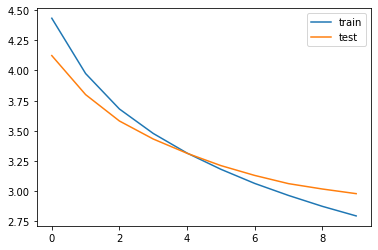

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현
    * seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다
    * 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 함

In [53]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [55]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [56]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [57]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트하기
    * 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인
    * 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 생성
        - Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외
        - Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [65]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i == 'eostoken' or i == 0):  # eostoken이거나 패딩 토큰인 경우 종료
            break
        temp = temp + tar_index_to_word[i] + ' '
    return temp

In [66]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약 비교
for i in range(min(50, len(encoder_input_test)), min(100, len(encoder_input_test))):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : wework shared office spaces across bangalore community locations aside opportunities network make connections unique common areas phone booths micro coffee wework offers everything need make life living 
실제 요약 : sostoken why for co working space in bengaluru 
예측 요약 :  to be made


원문 : indian rounder hardik pandya posted video batsman shikhar dhawan dancing washroom manchester play first england tuesday two seen matching dance moves facing mirror caught action love dancing singing read post caption 
실제 요약 : sostoken pandya posts video of him and dhawan dancing in 
예측 요약 :  hardik pandya shares picture with


원문 : goa town country planning minister friday said state become expensive low budget indian tourists visiting adding goa competing kerala sri lanka southeast asia said focus quality tourism rather tourism merely 
실제 요약 : sostoken goa should low budget indian tourists minister 
예측 요약 :  india to be in india rajnath


원문 : union home minister rajnath singh sunday said talks pak

## 추출적 요약

In [74]:
import requests
from summa.summarizer import summarize
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(data[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

**Summa의 summarize()**

    * text (str) : 요약할 테스트.
    * ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
    * words (int or None, optional) – 출력에 포함할 단어 수. 
    * 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
    * split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환
    

In [83]:
# 'Text' 열을 선택하고 문자열로 변환
text_data = data['text'].astype(str).str.cat(sep=' ')

print('Summary:')
print(summarize(text_data[:1500], ratio=0.005))

Summary:



In [ ]:
print('Summary:')
print(summarize(text_data[:1500], ratio=0.005, split=True))

In [71]:
print('Summary:')
print(summarize(text_data[:1500], words=50))

Summary:



### 회고

    * 모델 결과를 통해 내 생각보다 예상치 못한 결과(잘못 요약)가 나왔다. 
      시간 상 이유로 epoch을 많이 줄였는데, 학습 부분에서 충분치 못했는지, 전처리 부분에서 잘못된 부분이 있는건지, 
      어느 부분에 의해 이러한 결과가 나왔는지 확인해 볼 필요가 있을 것 같다.
    * 개념적인 부분에서 아직 숙지가 덜 된 것같다. 시간을 들여서 더 깊게 이해해볼 필요가 있을 것 같다.
    * 아직은 갈 길이 멀지만, 자연어처리와 친해지면 좋겠다 :) 